# Identifing and Plotting Candidate Statistical Relationships

In this program, we will be qualitatively identifying  relationships between in game performance and the statistics that represent the game. A trivial example would be "how does third down conversion rate correlate with the point spread in the game." Obviously, teams with a higher conversion percentage will be able to score more points because their drives will be longer.

Ideally, when comparing teams that consistently perform well in key statistics, and comparing them to teams who, to put it bluntly, underperform, we will be able to predict the resulting point spread. In other words, this program is qualitatively assessing the correlation between statistics and success, to later be used in the machine learning algorithm.

### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

### Writing Functions to Parse Data

In [2]:
def returnFullSeasonStats(teamName, yearArr):
    """
    Goes into stats folder and reads in the both stats and Info csv files
    Concats them into a single data frame and returns them.

    Args:
        teamName (string): the team name matching the name within Stats File
        yearArr (array of ints): Allows to make sure we can pull specific year ranges
    Returns:
        TeamPDStats: Pandas Data-Frame of team game stats from all seasons collected
        teamPDInfo: Pandas Data-Frame of game info from all seasons collected
    """
    #sets up first iteration so i only grab row labels one time
    firstSeasonStats = True
    firstSeasonInfo = True

    #data frame holding things like total yards for every season collected
    teamPDStats = pd.DataFrame()
    #data frame holding things like weather for every game in every season collected
    teamPDInfo = pd.DataFrame()
    #gets all csv files for a team
    dirList = os.listdir(f"Stats/{teamName}/")
    for file in dirList:
        #makes sure we only grab the years we want
        if(int(file[-8:-4]) not in yearArr):
            continue
        #if stats then --> else, it is the game info. 
        if "Stats" in file:
            #if on the first seasons gathered --> read then concat to master stats
            if firstSeasonStats:
                curr = pd.read_csv(f"Stats/{teamName}/{file}")
                #axis 1 because I want it to concat to columns, not more rows
                teamPDStats = pd.concat([teamPDStats, curr],axis = 1)
                firstSeasonStats = False
            elif not firstSeasonStats:
                curr = pd.read_csv(f"Stats/{teamName}/{file}")
                #drop unwanted labels before concecrating 
                curr = curr.drop(columns=['Unnamed: 0', 'Unnamed: 1'])
                teamPDStats = pd.concat([teamPDStats, curr],axis = 1)
        else:
            #if on the first seasons gathered --> read then concat to master stats
            if firstSeasonInfo:
                curr = pd.read_csv(f"Stats/{teamName}/{file}")
                #axis 1 because I want it to concat to columns, not more rows
                teamPDInfo = pd.concat([teamPDInfo, curr],axis = 1)
                #once not the first season
                firstSeasonInfo = False
            elif not firstSeasonInfo:
                curr = pd.read_csv(f"Stats/{teamName}/{file}")
                #drop unwanted labels
                curr = curr.drop(columns=['Unnamed: 0', 'Unnamed: 1'])
                teamPDInfo = pd.concat([teamPDInfo, curr],axis = 1)
    #returns the collected, concected pds. 
    return teamPDStats, teamPDInfo
 


def returnSpecificRow(teamDataFrame, statName):
    """
    Goes into given dataframe and pulls out a requested row from the stat name

    Args:
        teamDataFrame (pandas Dataframe): passed dataframe that contains row to extract.
        statName (string): Name of row to extract 
    Returns:
        statPD: Pandas Data-Frame of row we want to extract
    """
    #mask to pull the spectific row we want, case insensitive
    mask = teamDataFrame["Unnamed: 1"].str.lower() == statName.lower()
    #creates the dataframe and ignores the first two labeling columns
    statPD = pd.DataFrame(teamDataFrame.loc[mask].iloc[:, 2:].values.flatten())
    return statPD


def extractNumberFromString(givenString):
    """
    Extracts a float from a string with a format. Requires this number to have a decimal point

    Args:
        givenString (string): string with number inside
    Returns:
        extractedFloat (float): the extracted number within the string
    """
    extractedFloat = givenString.extract(r"(\d+\.\d*)").astype(float)
    return extractedFloat

def getSpreadandScores(currFullSeasonStats, currFullSeasonInfo, currTeam):
    """
    parses out a dataframes data includin the spread all the scores,
        the difference in game scores ect. 
    Args:
        currFullSeasonStats (pandas Dataframe): dataframe with all the stats from 
            potentially mutliple seasons.
        
        currFullSeasonInfo (pandas Dataframe): dataframe with all the game info from 
            potentially mutliple seasons. IE spread, weather, ect.

        currTeam (str): the name of team currently interested in
    Returns:
        teamBeatSpread (Dataframe): how many points team beat spread by. Postive means won
        scoreDifference (Dataframe): differnce between team score and opponent score across seasons
        vegasSpread (Dataframe): Vegas predicted point spread
        teamScoreFloat (Dataframe): team of interest scores throughout seasons
        oppScoreFloat (Dataframe): opponents scores throughout seasons
    """
    #3 letter abbrivation 
    teamAbbr = currFullSeasonStats["Unnamed: 0"].iloc[0]
    #geting team scores and opp scores
    teamsScore = returnSpecificRow(currFullSeasonStats, f"{teamAbbr} Score")
    opponentScore = returnSpecificRow(currFullSeasonStats, "Opp Score")
    #getting total score
    teamScoreFloat = teamsScore[0].astype(float) 
    oppScoreFloat = opponentScore[0].astype(float)
    #getting actual spread
    scoreDifference = pd.DataFrame(teamScoreFloat - oppScoreFloat)
    #getting vegas over under
    overUnder = returnSpecificRow(currFullSeasonInfo, "Over/Under")
    #getting vegas spread
    spread = returnSpecificRow(currFullSeasonInfo, "Vegas Line")
    #This takes the pandas array, with info like "45.5 (over)" and takes just the number
    #extract takes a regular exprexsion (regex) "\d" grabs number before decimal place
    #"/.?" grabs the the decimal point and "\d*" grabs the post decimal place. 
    #() tells .extract to only take what is in the parentheses until white space.
    overUnderNumber = extractNumberFromString(overUnder[0].str)
    spreadNumber =  extractNumberFromString(spread[0].str)
    #takes out nan and label rows
    overUnderNumber = overUnderNumber
    vegasSpread = spreadNumber
    # print(vegasSpread)
    #convering spread to be in format as vegas. 
    for i in range(1,len(scoreDifference)):
        if ("nan" not in str(spread[0][i])) and currTeam not in spread[0][i]:
            #if broncos were favored then switch there real spread to reflect they won
            #locate the row i in first column make it negative. 
            vegasSpread.iloc[i, 0] = -1 * vegasSpread.iloc[i, 0]

    teamBeatSpread = scoreDifference[:] - vegasSpread[:]
    
    return teamBeatSpread, scoreDifference, vegasSpread, teamScoreFloat, oppScoreFloat


def getConversionRates(currFullSeasonStats, statName):
    """
    Grabs and parses conversion rates into floats. Originally in x-y format (ie 3-10)
    This function coverts x-y --> x/y to get the rate of conversion as a float

    Args:
        currFullSeasonStats (pandas Dataframe): Dataframe with the stats from years selected
        statName (string): Name of row to extract 
    Returns:
        finalRate: Pandas Data-Frame of conversion rates in float form
    """
    #will store the conversion rate floats
    converRateFloatArr = []
    #grabs the selected conversion rate row
    converRate = returnSpecificRow(currFullSeasonStats, statName)
    for i in range(len(converRate)):
        #finds the - splitting 
        index = converRate[0][i].find("-")
        if(int(converRate[0][i][index +1:]) == 0):
            #if there were zero attemps to convert (mainly for 4th down)
            converRateFloatArr.append(np.nan)
        else:
            #divide the first number by the second to get ratio and append to growing np.array
            converRateFloatArr.append(int(converRate[0][i][:index]) / int(converRate[0][i][index +1:]))
    # convert into pandas dataframe. 
    finalRate = pd.DataFrame(converRateFloatArr)
    return(finalRate)


### Gathering Statistics to be Analysed

In [ ]:
#directory where Stats was stored
directory = 'Stats/'

yearArr = [2017,2018,2019,2020,2021,2022,2023, 2024]

#array of each directory within stats
TeamNamesArr= os.listdir(directory)

#defining pandas arrays to be used for combining all teams data across all seasons.
fullScoreDifference = pd.DataFrame()
fullvegasSpread = pd.DataFrame()
fullThirdDownConversionRate = pd.DataFrame()
fullOppThirdDownConversionRate = pd.DataFrame()
fullFourthDownConversionRate = pd.DataFrame()
fullOppFourthDownConversionRate = pd.DataFrame()


for team in TeamNamesArr:
    print(f"Attemping to get dad for {team}")
    if team == ".DS_Store":
        continue
    # Getting each individual teams stats for the length of the specified season range
    currFullSeasonStats, currFullSeasonInfo = returnFullSeasonStats(team, yearArr)
    thirdDownConversionRate = getConversionRates(currFullSeasonStats, "Third Down Conv.")
    fourthDownConversionRate = getConversionRates(currFullSeasonStats, "Fourth Down Conv.")
    oppThirdDownConversionRate = getConversionRates(currFullSeasonStats, "Opp_Third Down Conv.")
    oppFourthDownConversionRate = getConversionRates(currFullSeasonStats, "Opp_Fourth Down Conv.")
    currFullSeasonStats, currFullSeasonInfo = returnFullSeasonStats(team, yearArr)
    teamBeatSpread, scoreDifference, vegasSpread, teamScoreFloat, oppScoreFloat = getSpreadandScores(currFullSeasonStats, currFullSeasonInfo, team)
                
    # Getting combining every teams data, for easier examination of broad statistics 
    fullScoreDifference = pd.concat([fullScoreDifference, scoreDifference], axis = 1)
    fullvegasSpread = pd.concat([fullvegasSpread, vegasSpread], axis = 1)
    fullThirdDownConversionRate = pd.concat([fullThirdDownConversionRate, fullThirdDownConversionRate], axis = 1)
    fullOppThirdDownConversionRate = pd.concat([fullOppThirdDownConversionRate, fullOppThirdDownConversionRate], axis = 1)
    fullFourthDownConversionRate = pd.concat([fullFourthDownConversionRate, fullFourthDownConversionRate], axis = 1)
    fullOppFourthDownConversionRate = pd.concat([fullOppFourthDownConversionRate, oppFourthDownConversionRate], axis = 1)
    print(f"Combined Data for {team}")
    

Combined Data for Broncos
Combined Data for Commanders
Combined Data for Dolphins
Combined Data for Vikings
Combined Data for Chargers
Combined Data for Cheifs
Combined Data for Titans


ValueError: invalid literal for int() with base 10: '27:13'

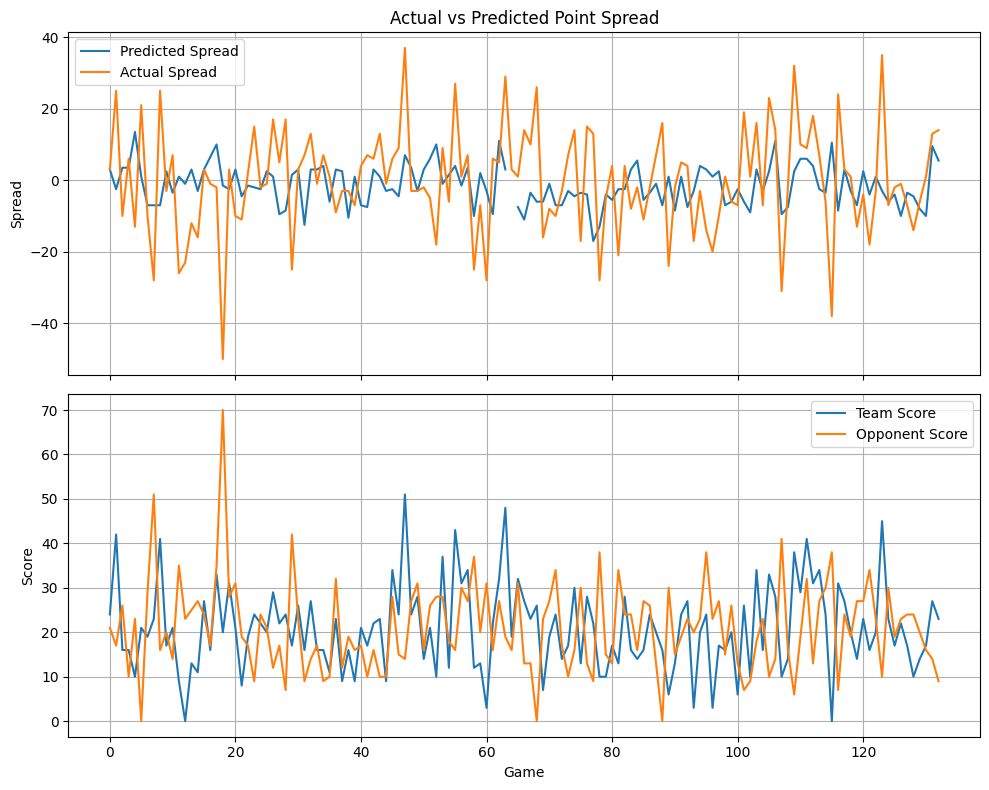

In [ ]:
# gamerange = np.arange(len(vegasSpread))
# fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
# # Top subplot: spreads
# axs[0].plot(gamerange, vegasSpread, label="Predicted Spread")
# axs[0].plot(gamerange, scoreDifference, label="Actual Spread")
# axs[0].set_ylabel("Spread")
# axs[0].set_title("Actual vs Predicted Point Spread")
# axs[0].grid(True)
# axs[0].legend()

# # Bottom subplot: scores
# axs[1].plot(gamerange, teamScoreFloat, label="Team Score")
# axs[1].plot(gamerange, oppScoreFloat, label="Opponent Score")
# axs[1].set_xlabel("Game")
# axs[1].set_ylabel("Score")
# axs[1].grid(True)
# axs[1].legend()

# plt.tight_layout()
# plt.show()
